In [ ]:
from plotnine import *
import pandas as pd
import numpy as np

In [10]:
# time = "2024-03-29_04:53"
time = "2024-03-29_07:23"
time = "2024-03-31_15:54"
time = "2024-03-31_16:37"
time = "2024-03-31_17:12"
time = "2024-04-01_15:42"
time = "2024-04-01_17:06"
time = "2024-04-01_18:11"
time = "2024-04-16_16:47"
time = "2024-04-18_19:23"
time = "2024-04-18_20:30"
time = "2024-04-19_01:29"
time = "2024-04-19_09:39"
time = "2024-05-19_16:34"
time = "2024-05-19_16:58"
time = "2024-05-19_17:38"
time = "2024-05-19_18:55"
time = "2024-05-20_04:15"
time = "2024-05-20_10:30"
time = "2024-05-29_13:27"
time = "2024-06-10_12:52" # EUR_USD_M15
time = "2024-06-10_19:47" # GBP_USD_M15
time = "2024-06-10_22:59" # USD_JPY_M15
time = "2024-06-11_04:01" # USD_CHF_M15
time = "2024-06-11_04:14" # USD_CAD_M15
time = "2024-06-11_11:42" # AUD_USD_M15
time = "2024-06-11_23:43" # AUD_JPY_M15
time = "2024-06-11_23:48" # AUD_CAD_M15
time = "2024-06-12_08:44" # EUR_JPY_M15
time = "2024-06-12_08:48" # GBP_CHF_M15
time = "2024-06-12_08:52" # GBP_JPY_M15


time = "2024-07-12_11:31" # GBP_USD_M15

df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/results/{time}_results.csv")

# df['test_cumsum_annualized_return'] = df['test_cumsum_annualized_return'] * -1
# remove where dist_measure is 2
# remove where future_candles is 5
# remove where n_clusters is 150 or 200
# remove where log_return_threshold is greater than 0.01
# remove where calmar_ratio_threshold is not 2

# df = df[df["dist_measure"] != 2]
# df = df[df["window"] < 5]
# df = df[df["random_state"] == 42]
# df = df[df["test_size"] == 2880]
# df = df[df["algorithm"] == "kmeans"]
# df = df[(df["test_negative_sharpe_ratio"] >= 1) | (df["test_sharpe_ratio"] >= 1)]
df = df[(df["test_inverse_sharpe_ratio"] >= 2.1) | (df["test_sharpe_ratio"] >= 2.1)]

# df = df[(df["algorithm"] == 'gaussian_mixture')]
# df = df[(df["max_k_labels"] == 1)]
# df = df[(df["random_state"] == 200)]

df

,window,train_total_annualized_return,train_total_actual_return,train_total_trades,test_total_annualized_return,test_total_actual_return,test_total_trades,train_cumulative_annualized_return,train_cumulative_actual_return,train_sharpe_ratio,test_cumulative_annualized_return,test_cumulative_actual_return,test_sharpe_ratio,test_inverse_sharpe_ratio,max_cluster_labels,num_clusters,clustering_algorithm,train_period,test_period,random_seed
70015,0,1.50,150.0,271,0.09,9.0,61,1.50,150.0,4.058695,0.09,9.0,2.126340,-2.216136,5,70,kmeans,3840,960,21
70016,1,1.58,158.0,300,0.28,28.0,64,3.08,308.0,4.058695,0.37,37.0,2.126340,-2.216136,5,70,kmeans,3840,960,21
70017,2,1.51,151.0,334,0.27,27.0,81,4.59,459.0,4.058695,0.64,64.0,2.126340,-2.216136,5,70,kmeans,3840,960,21
70018,3,2.27,227.0,344,0.55,55.0,69,6.86,686.0,4.058695,1.19,119.0,2.126340,-2.216136,5,70,kmeans,3840,960,21
70019,4,2.62,262.0,355,0.42,42.0,104,9.48,948.0,4.058695,1.61,161.0,2.126340,-2.216136,5,70,kmeans,3840,960,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520925,121,2.26,226.0,504,0.44,44.0,98,497.04,49704.0,3.196673,81.86,8186.0,2.146242,-2.211225,5,70,gaussian_mixture,5760,960,80
520926,122,1.91,191.0,458,0.37,37.0,59,498.95,49895.0,3.196673,82.23,8223.0,2.146242,-2.211225,5,70,gaussian_mixture,5760,960,80
520927,123,2.64,264.0,653,0.65,65.0,89,501.59,50159.0,3.196673,82.88,8288.0,2.146242,-2.211225,5,70,gaussian_mixture,5760,960,80
520928,124,3.49,349.0,696,0.96,96.0,111,505.08,50508.0,3.196673,83.84,8384.0,2.146242,-2.211225,5,70,gaussian_mixture,5760,960,80


/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


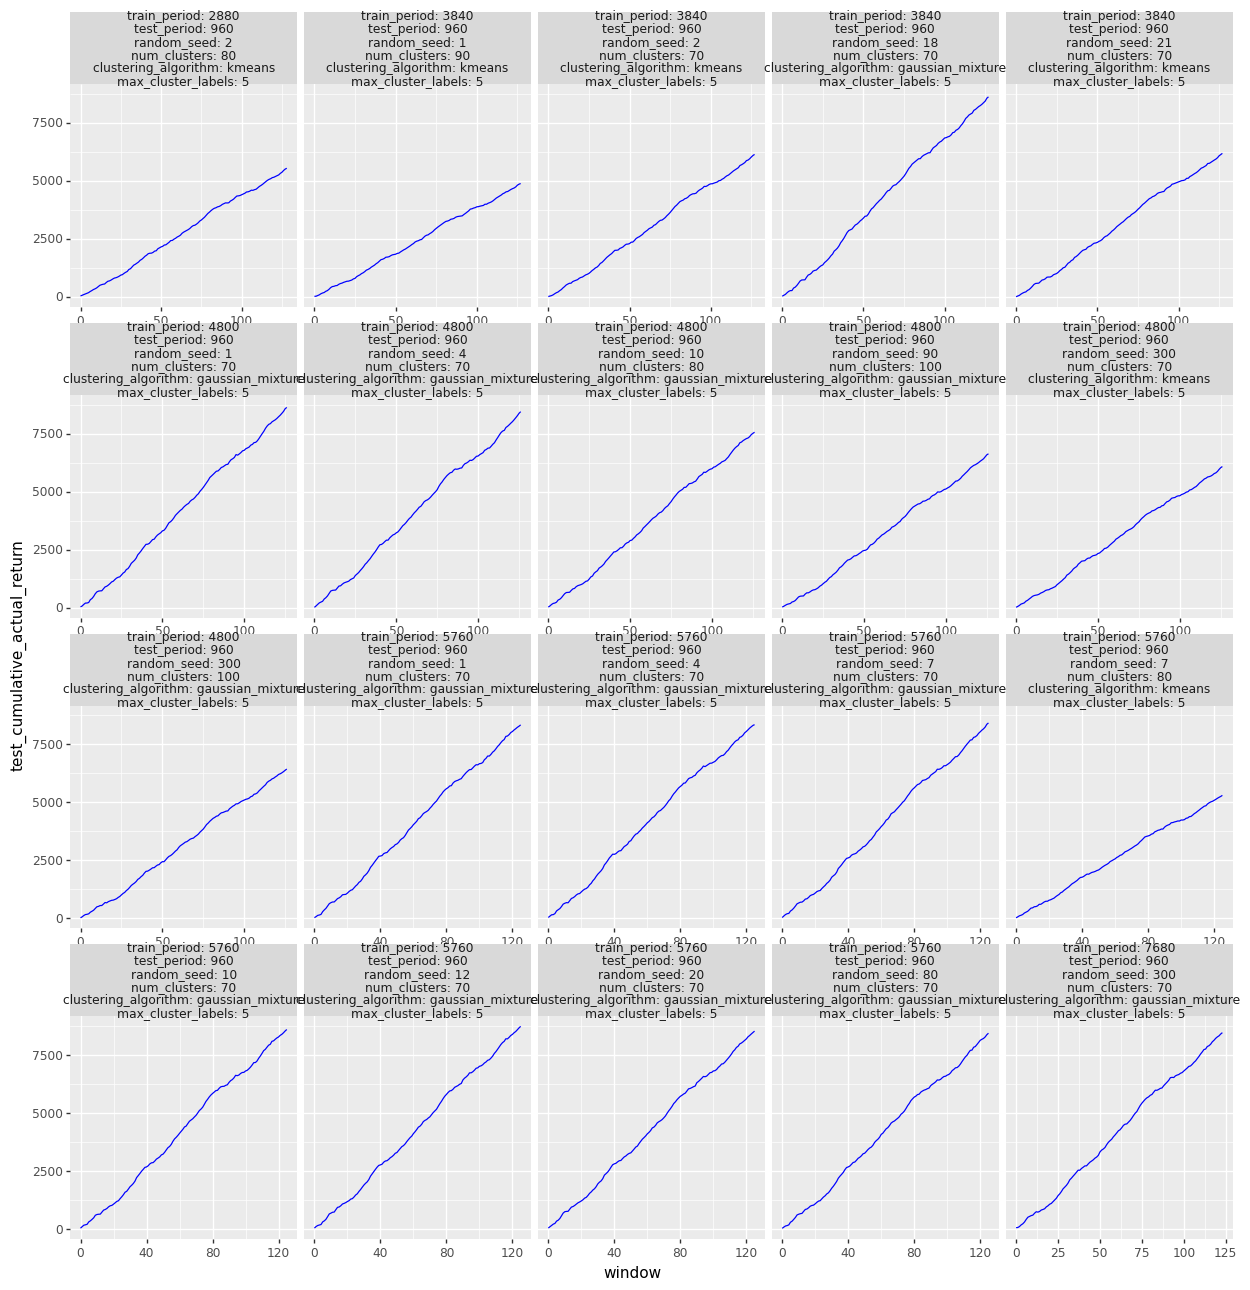

In [15]:
p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumulative_actual_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_avg_calmar_ratio"), color="red")
# p = p + facet_wrap("~train_period + random_seed", scales="free_x", labeller="label_both")
p = p + facet_wrap("~train_period + test_period + random_seed + num_clusters + clustering_algorithm + max_cluster_labels", scales="free_x", labeller="label_both")
# p = p + theme(figure_size=(35, 35))
p = p + theme(figure_size=(15, 15))
print(p)

In [ ]:

time = "2024-03-14_19:00"
df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/kmeans/results/{time}_results.csv")

p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumsum_annualized_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_cumsum_annualized_return"), color="red")
p = p + facet_wrap("~train_size + test_size + random_state", scales="free_x", labeller="label_both")
p = p + theme(axis_text_x=element_text(angle=90), figure_size=(30, 30))
print(p)